# This notebook is the implementation of:
- OpenAI's GPT-4o
- Meta's Llama 3.3 70B
- Anthropic's Claude 3.5 Haiku
- Amazon's Titan Text G1 Premier
- BERT w chunking
- Longformer

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, LongformerTokenizer, LongformerForSequenceClassification
import torch
from torch.nn.functional import softmax
import os
import pandas as pd
import json
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import boto3
from botocore.config import Config
from openai import OpenAI

load_dotenv("codes.env")

# AWS credentials
aws_access_key = os.environ.get("AWS_ACCESS_KEY_ID")
aws_secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
aws_region = os.environ.get("AWS_REGION")
# OpenAI credentials
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# AWS Bedrock model configurations (relates to cross-region inference ARN IDs)
MODEL_ID_LLAMA = "arn:aws:bedrock:us-east-1:874280117166:inference-profile/us.meta.llama3-3-70b-instruct-v1:0"
MODEL_ID_CLAUDE = "us.anthropic.claude-3-5-haiku-20241022-v1:0"
MODEL_ID_TITAN = "amazon.titan-text-premier-v1:0"

# prevent bedrock timeout
config = Config(read_timeout=1000)

client = boto3.client(
    "bedrock-runtime",
    region_name=aws_region,
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    config=config
)

# previously mapped file to topics
mapping_file_path = 'file_topic_mapping.csv'
data_folder_path = 'W2_Cleaned_Data'
file_topic_mapping = pd.read_csv(mapping_file_path)
unique_topics = file_topic_mapping['folder_name'].unique().tolist()
unique_topics_str = ', '.join(unique_topics)

# read a .txt file's content
def read_txt_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# map outputs to categories
def map_to_category(predicted_output):
    predicted_output = predicted_output.lower().strip()
    for topic in unique_topics:
        if topic.lower() in predicted_output:
            return topic
    return "unknown"

# OpenAI's GPT-4o
def evaluate_topic_with_gpt4o(file_content):
    try:
        response = openai_client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an expert document classifier."},
                {"role": "user", "content": f"Classify the following text into one of these topics: {unique_topics_str}. \n{file_content}"},
            ],
            model="gpt-4o",
            temperature=0,
        )
        predicted_topic = response.choices[0].message.content
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return "unknown"

# AWS Bedrock (Meta's Llama 3.3)
def evaluate_topic_with_llama(file_content):
    try:
        prompt = f"Classify the following text into only one of these topics: {unique_topics_str}. \n{file_content}"
        formatted_prompt = f"""
            <|begin_of_text|>
            <|start_header_id|>user<|end_header_id|>
            {prompt}
            <|eot_id|>
            <|start_header_id|>assistant<|end_header_id|>
            """
        response = client.invoke_model(
            modelId=MODEL_ID_LLAMA,
            body=json.dumps({
                "prompt": formatted_prompt,
                "max_gen_len": 512,
                "temperature": 0,
            }),
            contentType="application/json"
        )
        response_body = json.loads(response['body'].read())
        predicted_topic = response_body["generation"]
        if not predicted_topic:
            print("Empty response from AWS Bedrock Llama, defaulting to unknown.")
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling AWS Bedrock API: {e}")
        return "unknown"

# validate and trim input text since both Titan and Claude models have length limits on AWS Bedrock
def validate_and_trim_text(input_text, max_length):
    if len(input_text) > max_length:
        # print(f"Input text length of {len(input_text)} exceeds max length {max_length} of model. Trimming it.")
        return input_text[:max_length]
    return input_text

# AWS Bedrock (Amazon's Titan Text G1 Premier)
def evaluate_topic_with_titan(file_content):
    try:
        # Titan API's maximum input length
        MAX_LENGTH_TITAN = 149500
        validated_text = validate_and_trim_text(file_content, MAX_LENGTH_TITAN)
        
        # prompt for the model
        prompt = (
            f"Classify the following text into only one of these topics: {unique_topics_str}. \n"
            f"{validated_text}"
        )

        conversation = [
            {
                "role": "user",
                "content": [{"text": prompt}],
            }
        ]

        response = client.converse(
            modelId=MODEL_ID_TITAN,
            messages=conversation,
            inferenceConfig={
                "maxTokens": 512,
                "temperature": 0,
                "topP": 0.9,
            },
        )

        response_text = response["output"]["message"]["content"][0]["text"]
        if not response_text:
            print("Empty response from Titan API, defaulting to unknown.")
            return "unknown"

        # map output topic to category
        return map_to_category(response_text)

    except (ClientError, Exception) as e:
        print(f"Error calling Titan API: {e}")
        return "unknown"

# AWS Bedrock (Anthropic's Claude 3.5 Haiku)
def evaluate_topic_with_claude(file_content):
    try:

        prompt = (
            f"Classify the following text into only one of these topics: {unique_topics_str}. \n"
            f"{file_content}"
        )

        conversation = [
            {
                "role": "user",
                "content": [{"text": prompt}],
            }
        ]

        response = client.converse(
            modelId=MODEL_ID_CLAUDE,
            messages=conversation,
            inferenceConfig={
                "maxTokens": 512,
                "temperature": 0,
                "topP": 0.999,
            },
        )

        response_text = response["output"]["message"]["content"][0]["text"]
        if not response_text:
            print("Empty response from Claude API, defaulting to unknown.")
            return "unknown"

        # map output topic to category
        return map_to_category(response_text)

    except (ClientError, Exception) as e:
        print(f"Error calling Claude API: {e}")
        return "unknown"

# Load BERT Tokenizer and Model
def load_bert_model():
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(unique_topics))
    return tokenizer, model

# Load Longformer Tokenizer and Model
def load_longformer_model():
    tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
    model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=len(unique_topics))
    return tokenizer, model

# BERT w chunking
def evaluate_topic_with_bert(file_content, tokenizer, model):
    model.eval()
    chunk_size = 512
    overlap = 100

    tokens = tokenizer(file_content, truncation=False, return_tensors="pt")
    input_ids = tokens["input_ids"].squeeze()

    chunks = [
        input_ids[i:i + chunk_size]
        for i in range(0, len(input_ids), chunk_size - overlap)
    ]

    # base pretrained model doesn't know about new classes
    logits_list = []
    with torch.no_grad():
        for chunk in chunks:
            chunk = chunk.unsqueeze(0)
            outputs = model(chunk)
            logits_list.append(outputs.logits)

    # use weighted average of chunks for final classification decision
    aggregated_logits = torch.mean(torch.stack(logits_list), dim=0)
    predicted_label = torch.argmax(aggregated_logits, dim=1).item()
    return unique_topics[predicted_label]

# Longformer
def evaluate_topic_with_longformer(file_content, tokenizer, model):
    model.eval()
    max_tokens = 4096

    tokens = tokenizer(file_content, truncation=True, max_length=max_tokens, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**tokens)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).item()
    return unique_topics[predicted_label]

# Initialize models
bert_tokenizer, bert_model = load_bert_model()
longformer_tokenizer, longformer_model = load_longformer_model()

# Evaluate files function
def evaluate_files():
    results = []

    for _, row in file_topic_mapping.iterrows():
        relative_path = row['file_name']
        expected_topic = row['folder_name'].strip()

        file_path = os.path.join(data_folder_path, expected_topic, relative_path)

        content = read_txt_file(file_path)
        if not content:
            continue

        predicted_topic_gpt4o = evaluate_topic_with_gpt4o(content)
        predicted_topic_llama = evaluate_topic_with_llama(content)
        predicted_topic_claude = evaluate_topic_with_claude(content)
        predicted_topic_titan = evaluate_topic_with_titan(content)
        predicted_topic_bert = evaluate_topic_with_bert(content, bert_tokenizer, bert_model)
        predicted_topic_longformer = evaluate_topic_with_longformer(content, longformer_tokenizer, longformer_model)

        results.append({
            'file_path': relative_path,
            'expected_topic': expected_topic,
            'predicted_topic_gpt4o': predicted_topic_gpt4o,
            'predicted_topic_llama': predicted_topic_llama,
            'predicted_topic_claude': predicted_topic_claude,
            'predicted_topic_titan': predicted_topic_titan,
            'predicted_topic_bert': predicted_topic_bert,
            'predicted_topic_longformer': predicted_topic_longformer
        })

    return pd.DataFrame(results)

# Evaluate all files
results_df = evaluate_files()

# Save results
output_csv_path = 'topic_evaluation_results.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"Evaluation results saved to {output_csv_path}")

GPT-4o Classification Report:
                                    precision    recall  f1-score   support

                               AML       0.94      0.76      0.84        21
                  consumer_finance       0.00      0.00      0.00         9
                        employment       0.80      1.00      0.89         8
             financial_regulations       0.17      0.36      0.24        11
              financial_statements       0.78      1.00      0.88         7
       investments_market_research       1.00      0.86      0.92         7
                             loans       0.50      0.67      0.57         6
                              ndas       1.00      1.00      1.00         5
                      partnerships       1.00      0.67      0.80         3
risk_assessment_reports_frameworks       0.67      0.67      0.67         9
                   risk_management       0.73      0.59      0.65        27
                          taxation       1.00      1.00  

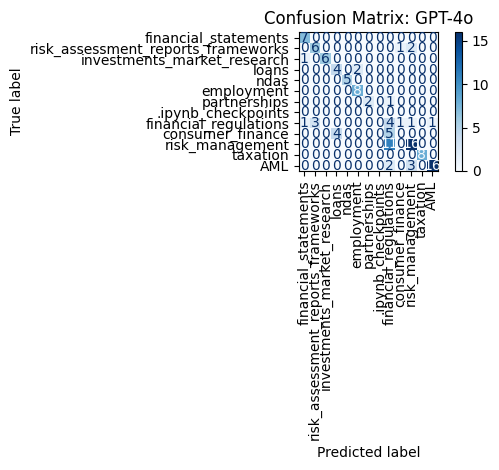

AWS Bedrock Llama Classification Report:
                                    precision    recall  f1-score   support

                               AML       1.00      0.14      0.25        21
                  consumer_finance       0.00      0.00      0.00         9
                        employment       0.89      1.00      0.94         8
             financial_regulations       0.12      0.18      0.15        11
              financial_statements       0.70      1.00      0.82         7
       investments_market_research       1.00      0.86      0.92         7
                             loans       0.45      0.83      0.59         6
                              ndas       1.00      1.00      1.00         5
                      partnerships       1.00      0.67      0.80         3
risk_assessment_reports_frameworks       0.32      0.67      0.43         9
                   risk_management       0.61      0.70      0.66        27
                          taxation       1.00 

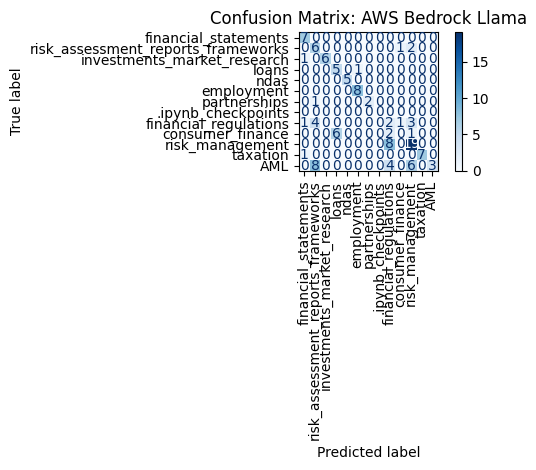

AWS Bedrock Claude Classification Report:
                                    precision    recall  f1-score   support

                               AML       0.90      0.43      0.58        21
                  consumer_finance       0.00      0.00      0.00         9
                        employment       0.80      1.00      0.89         8
             financial_regulations       0.17      0.55      0.26        11
              financial_statements       0.60      0.86      0.71         7
       investments_market_research       1.00      0.71      0.83         7
                             loans       0.33      0.50      0.40         6
                              ndas       1.00      1.00      1.00         5
                      partnerships       1.00      0.33      0.50         3
risk_assessment_reports_frameworks       0.60      0.67      0.63         9
                   risk_management       0.65      0.48      0.55        27
                          taxation       0.80

/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/pytho

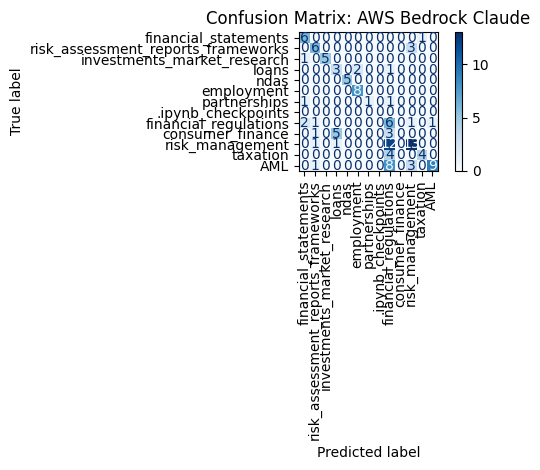

AWS Bedrock Titan Classification Report:
                                    precision    recall  f1-score   support

                               AML       1.00      0.10      0.17        21
                  consumer_finance       0.00      0.00      0.00         9
                        employment       1.00      0.88      0.93         8
             financial_regulations       0.08      0.55      0.15        11
              financial_statements       0.18      0.57      0.28         7
       investments_market_research       0.00      0.00      0.00         7
                             loans       0.00      0.00      0.00         6
                              ndas       1.00      0.80      0.89         5
                      partnerships       0.00      0.00      0.00         3
risk_assessment_reports_frameworks       0.33      0.11      0.17         9
                   risk_management       0.00      0.00      0.00        27
                          taxation       0.00 

/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/pytho

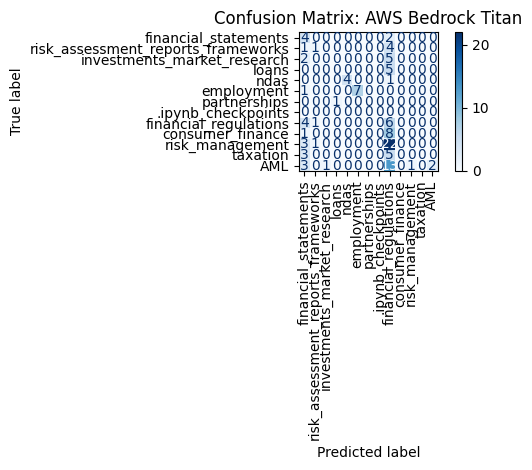

BERT Classification Report:
                                    precision    recall  f1-score   support

                               AML       0.00      0.00      0.00        21
                  consumer_finance       0.00      0.00      0.00         9
                        employment       0.00      0.00      0.00         8
             financial_regulations       0.00      0.00      0.00        11
              financial_statements       0.00      0.00      0.00         7
       investments_market_research       0.00      0.00      0.00         7
                             loans       0.00      0.00      0.00         6
                              ndas       0.06      0.40      0.11         5
                      partnerships       0.00      0.00      0.00         3
risk_assessment_reports_frameworks       0.00      0.00      0.00         9
                   risk_management       0.18      0.59      0.27        27
                          taxation       0.00      0.00    

/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


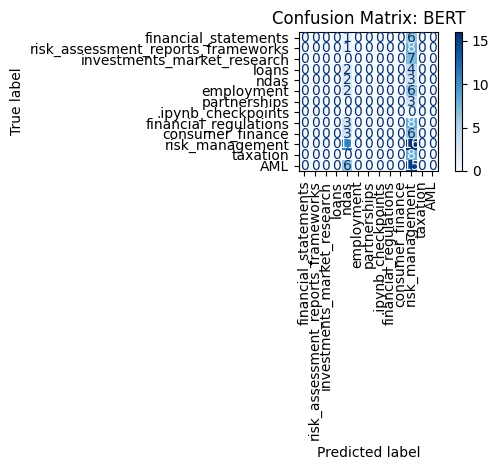

/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Longformer Classification Report:
                                    precision    recall  f1-score   support

                               AML       0.00      0.00      0.00        21
                  consumer_finance       0.00      0.00      0.00         9
                        employment       0.00      0.00      0.00         8
             financial_regulations       0.00      0.00      0.00        11
              financial_statements       0.00      0.00      0.00         7
       investments_market_research       0.00      0.00      0.00         7
                             loans       0.05      1.00      0.10         6
                              ndas       0.00      0.00      0.00         5
                      partnerships       0.00      0.00      0.00         3
risk_assessment_reports_frameworks       0.00      0.00      0.00         9
                   risk_management       0.00      0.00      0.00        27
                          taxation       0.00      0.

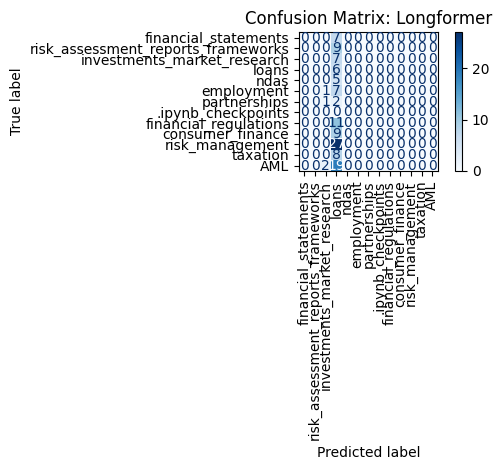

In [19]:
results_df = pd.read_csv("topic_evaluation_results.csv")

# Confusion matrix plotting
def plot_confusion_matrix(expected, predicted, model_name):
    cm = confusion_matrix(expected, predicted, labels=unique_topics)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_topics)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()

# Model performance evaluation
def evaluate_model_performance():
    expected_topics = results_df['expected_topic']

    models = {
        "GPT-4o": results_df['predicted_topic_gpt4o'],
        "AWS Bedrock Llama": results_df['predicted_topic_llama'],
        "AWS Bedrock Claude": results_df['predicted_topic_claude'],
        "AWS Bedrock Titan": results_df['predicted_topic_titan'],
        "BERT": results_df['predicted_topic_bert'],
        "Longformer": results_df['predicted_topic_longformer']
    }

    for model_name, predicted_topics in models.items():
        print(f"{model_name} Classification Report:")
        print(classification_report(expected_topics, predicted_topics))
        plot_confusion_matrix(expected_topics, predicted_topics, model_name)

# Run performance evaluation
evaluate_model_performance()

<Figure size 1200x800 with 0 Axes>

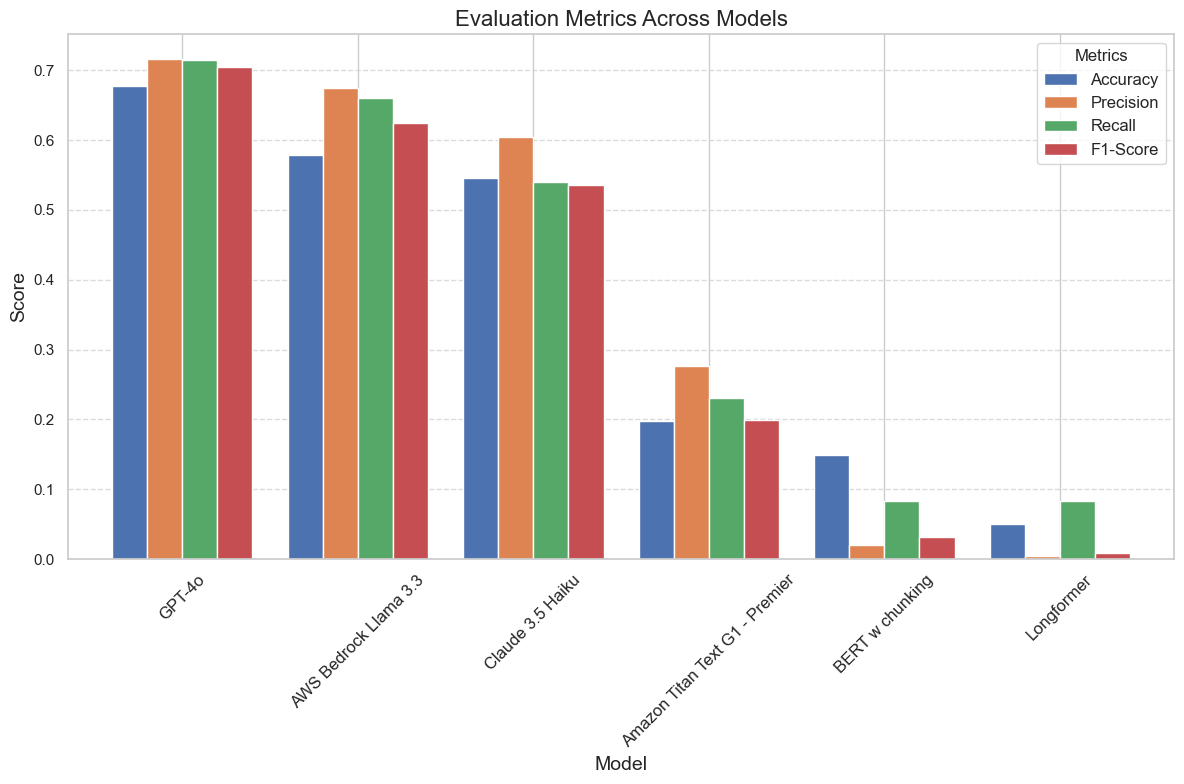

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

results_df = pd.read_csv("topic_evaluation_results.csv")

# Model names for evaluation
model_columns = ["predicted_topic_gpt4o", "predicted_topic_llama", "predicted_topic_claude", "predicted_topic_titan", "predicted_topic_bert", "predicted_topic_longformer"]
model_names = ["GPT-4o", "AWS Bedrock Llama 3.3", "Claude 3.5 Haiku", "Amazon Titan Text G1 - Premier", "BERT w chunking", "Longformer"]

metrics_data = []

for model_name, model_column in zip(model_names, model_columns):
    report = classification_report(
        results_df["expected_topic"], 
        results_df[model_column], 
        output_dict=True, 
        zero_division=0
    )
    
    metrics_data.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision": report["macro avg"]["precision"],
        "Recall": report["macro avg"]["recall"],
        "F1-Score": report["macro avg"]["f1-score"]
    })

metrics_df = pd.DataFrame(metrics_data)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 8), width=0.8)
plt.title("Evaluation Metrics Across Models", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Metrics", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()